In [1]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
 
plt.rcParams.update({'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

In [2]:
print(tf.__version__)

2.2.0


In [3]:
import pae.create_datasets as crd

In [4]:
from pae.fid_score_tf2 import *

ModuleNotFoundError: No module named 'torch'

In [5]:
PROJECT_PATH = r"/storage/homefs/ch19g182/Python/PAE-master2"  
PARAMS_PATH = os.path.join(PROJECT_PATH,'params')

param_file = 'params_gan2_-1_2_infoGAN_AE_default2_full_sigma'#
flow       = 'hybrid4_nepoch159'#'hybrid4_nepoch99' 
params     = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

In [6]:
if params['data_set'] in ['celeba','gan2','gan64']: #
    train_input_fn, eval_input_fn = crd.build_input_fns(params,label=params['class_label'],flatten=False,num_repeat=15)
else:
    import pae.load_data as ld
    load_funcs=dict(mnist=ld.load_mnist, fmnist=ld.load_fmnist, cifar10=ld.load_cifar10, gan64=ld.load_gan64)
    load_func                                         = partial(load_funcs[params['data_set']])
    x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_set'],flatten=False)

    if np.all(x_test)==None:
        x_test=x_valid

    def add_noise(x,sigma=0.1):
        nn = np.random.normal(size=np.shape(x))
        x  = x+nn*sigma
        return x

    x_train    = add_noise(x_train)/255.-0.5
    x_test     = add_noise(x_test)/255.-0.5
    x_valid    = add_noise(x_valid)/255.-0.5

loading gan2 dataset


In [7]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_dir          = os.path.join(params['module_dir'],flow)

In [8]:
params['plot_dir']=r'plots' #os.path.join(params['plot_dir'],flow)
if not os.path.isdir(params['plot_dir']):
    os.makedirs(params['plot_dir'])

In [9]:
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [10]:
from pae.model_tf2 import get_prior
print('encoder_path',encoder_path)
#print(decoder)

encoder_path /storage/homefs/ch19g182/Python/PAE-master/modules/gan2/class-1/latent_size2/net_type_infoGAN/loss_AE/default2_full_sigma/encoder


In [11]:
params['batch_size'] = 16
tf.reset_default_graph()
if params['data_set'] in ['celeba','gan2','gan64']:
    data               = eval_input_fn()
    x_val              = train_input_fn()
else:
    data          = tf.placeholder(shape=[None]+params['data_shape'],dtype=tf.float32)

latent_point  = tf.placeholder(shape=[None,params['latent_size']],dtype=tf.float32)
sample_size   = tf.placeholder_with_default(params['batch_size'], shape=[])
encoder       = hub.Module(encoder_path, trainable=False)
decoder       = hub.Module(generator_path, trainable=False)
nvp           = hub.Module(nvp_dir, trainable=False)
temp          = tf.placeholder_with_default(1.,shape=[])

prior         = get_prior(params['latent_size'])

encoded, _    = tf.split(encoder({'x':data},as_dict=True)['z'], 2, axis=-1)
decoded       = decoder({'z':encoded},as_dict=True)['x']
decoded_latent= decoder({'z':latent_point},as_dict=True)['x']

sigma         = tf.reduce_mean(tf.sqrt(tf.square(data-decoded)),axis=0)

samples         = prior.sample(sample_size)

decoded_samples = decoder({'z':samples},as_dict=True)['x']
nvp_samples     = nvp({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':samples}, as_dict=True)['fwd_pass']
u_samples       = nvp({'z_sample':encoded,'sample_size':1, 'u_sample':samples}, as_dict=True)['bwd_pass']
decoded_nvp_samples = decoder({'z':nvp_samples},as_dict=True)['x']

nvp_latent_point  = tf.placeholder(shape=[None,params['latent_size']],dtype=tf.float32)
nvp_samples_grid     = nvp({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':nvp_latent_point}, as_dict=True)['fwd_pass']
decoded_nvp_samples_grid = decoder({'z':nvp_samples_grid},as_dict=True)['x']

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [13]:
shape = params['data_shape']

In [15]:
#plt.plot(interp[:,0,0])
#plt.plot(interp[:,0,1])
#print(params['shape'])
print(params['batch_size'])
decoded_grid = []
z = np.linspace(-2,2,7)
z1,z2 = np.meshgrid(z,z)
grid = np.stack((z1.flatten(),z2.flatten()),axis=1)
print('grid shape',grid.shape)

grid1 = grid[0:16,:]
#nvp_samples_grid1     = nvp({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':grid1}, as_dict=True)['fwd_pass']
#img_grid = decoder({'z':nvp_samples_grid1},as_dict=True)['x']
#sess.run(decoded_latent, feed_dict={latent_point:nvp_samples_grid1})
#decoded_grid += [img_grid]
decoded_grid += [sess.run(decoded_nvp_samples_grid,feed_dict={nvp_latent_point:grid1})]


grid2 = grid[16:32,:]
decoded_grid += [sess.run(decoded_nvp_samples_grid,feed_dict={nvp_latent_point:grid2})]
#nvp_samples_grid2     = nvp({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':grid2}, as_dict=True)['fwd_pass']
#img_grid = decoder({'z':nvp_samples_grid2},as_dict=True)['x']
#decoded_grid += [img_grid]

grid3 = grid[32:48,:]
decoded_grid += [sess.run(decoded_nvp_samples_grid,feed_dict={nvp_latent_point:grid3})]
#nvp_samples_grid3     = nvp({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':grid3}, as_dict=True)['fwd_pass']
#img_grid = decoder({'z':nvp_samples_grid3},as_dict=True)['x']
#decoded_grid += [img_grid]

grid4 = grid[48:49,:]
hh_ = np.ones([16,2])
hh  = hh_ * grid4
decoded_grid += [sess.run(decoded_nvp_samples_grid,feed_dict={nvp_latent_point:hh})[0:1,:]]
#nvp_samples_grid4     = nvp({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':hh}, as_dict=True)['fwd_pass']
#img_grid = decoder({'z':nvp_samples_grid4},as_dict=True)['x']
#decoded_grid += [img_grid]

decoded_grid = np.concatenate(decoded_grid, axis=0 ) #np.asarray()
print('shae',decoded_grid.shape)
np.save(os.path.join(params['plot_dir'],'def2_grid_gan2d_pae.npy'),decoded_grid)

16
grid shape (49, 2)
shae (49, 64, 64, 3)


In [16]:
if params['data_set'] in ['celeba','gan2','gan64']:
    rec, d            = sess.run([decoded,data])
else:
    rec, d            = sess.run([decoded,data], feed_dict={data:x_valid[0:params['batch_size']]})
    
recs=[]
d=[]
delta = 1000%params['batch_size']
for ii in range(1000//params['batch_size']):
    if params['data_set'] in ['celeba','gan2','gan64']:
        recs+=[sess.run(decoded)]
        d+=[sess.run(data)]
    else:
        recs+=[sess.run(decoded, feed_dict={data:x_valid[ii*params['batch_size']:(ii+1)*params['batch_size']]})]

if params['data_set'] in ['celeba','gan2','gan64']:
    recs+=[sess.run(decoded)]
    d+=[sess.run(data)]
else:
    recs+=[sess.run(decoded, feed_dict={data:data_sample})]
    xval=x_valid
recs = np.asarray(recs).reshape([-1]+shape)[0:1000].reshape([1000,np.prod(shape)])
d = np.asarray(d).reshape([-1]+shape)[0:1000].reshape([1000,np.prod(shape)])
print(recs.shape)
print(d.shape)

(1000, 12288)
(1000, 12288)


In [17]:
full_sigma = np.sqrt(np.sum(np.square(255*(d+0.5)-255*(recs+0.5)),axis=1))
print('Mean Square error',np.mean(full_sigma))
print('with SD ',np.std(full_sigma))
np.save(os.path.join(params['plot_dir'],'def2_MSE.npy'),full_sigma)

Mean Square error 7170.481
with SD  2544.1465


In [18]:

random_nvp_samples=[]
for ii in range(10000//params['batch_size']+1):
    random_nvp_samples+=[sess.run(decoded_nvp_samples, feed_dict={temp:1.0})]
random_nvp_samples=np.asarray(random_nvp_samples).reshape((-1,np.prod(shape)))[0:1000]
np.save(os.path.join(params['plot_dir'],'def2_model_samples_gan2.npy'),random_nvp_samples)

"""
plt.figure(figsize=(6,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(25):
    plt.subplot(5,5,ii+1)
    plt.imshow(np.squeeze((random_nvp_samples[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'def1_nvp_samples.pdf'),bbox_inches='tight')
plt.show()

random_samples=[]
for ii in range(10000//params['batch_size']+1):
    random_samples+=[sess.run(decoded_samples)]
random_samples=np.asarray(random_samples).reshape((-1,np.prod(shape)))[0:10000]

plt.figure(figsize=(6,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(25):
    plt.subplot(5,5,ii+1)
    plt.imshow(np.squeeze((random_samples[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'raw_samples.pdf'),bbox_inches='tight')
plt.show()
"""

"\nplt.figure(figsize=(6,6))\nplt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)\nfor ii in range(25):\n    plt.subplot(5,5,ii+1)\n    plt.imshow(np.squeeze((random_nvp_samples[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)\n    plt.axis('off')\nplt.savefig(os.path.join(params['plot_dir'],'def1_nvp_samples.pdf'),bbox_inches='tight')\nplt.show()\n\nrandom_samples=[]\nfor ii in range(10000//params['batch_size']+1):\n    random_samples+=[sess.run(decoded_samples)]\nrandom_samples=np.asarray(random_samples).reshape((-1,np.prod(shape)))[0:10000]\n\nplt.figure(figsize=(6,6))\nplt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)\nfor ii in range(25):\n    plt.subplot(5,5,ii+1)\n    plt.imshow(np.squeeze((random_samples[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)\n    plt.axis('off')\nplt.savefig(os.path.join(params['plot_dir'],'raw_samples.pdf'),bbox_inches='tight')\nplt.show()\n"

In [25]:
try:
    latent_point1 = sess.run(encoded, feed_dict={data:data[0:params['batch_size']]})
    latent_point2 = sess.run(encoded, feed_dict={data:data[1:params['batch_size']+1]})
except:
    latent_point1 = sess.run(encoded)
    latent_point2 = sess.run(encoded)    
#latent_point1, latent_point2 = pickle.load(open('latent_points_for_interpolation_celeba.pkl','rb'))
#interp = latent_point1+(latent_point2-latent_point1)*np.arange(8)[:, None,None]/8.

#pickle.dump([latent_point1,latent_point2],open('latent_points_for_interpolation_celeba.pkl','wb'))

In [57]:
z = np.linspace(-2,2,7)
z1,z2 = np.meshgrid(z,z)
grid = np.stack((z1.flatten(),z2.flatten()),axis=1)
#print('grid shape',grid)
print('latent_point1',latent_point1.shape)
print(grid[0:7,])
latent_point1[0:7,:] = grid[0:7,[1,0]]
latent_point2[0:7,:] = grid[42:49,[1,0]]
#latent_point1 = grid[0:16,:]
#latent_point2 = grid[16:32,:]
interp = latent_point1+(latent_point2-latent_point1)*np.arange(7)[:, None,None]/6.
print(interp)
#print(latent_point2)
#print(grid)

latent_point1 (16, 2)
[[-2.         -2.        ]
 [-1.33333333 -2.        ]
 [-0.66666667 -2.        ]
 [ 0.         -2.        ]
 [ 0.66666667 -2.        ]
 [ 1.33333333 -2.        ]
 [ 2.         -2.        ]]
[[[-2.00000000e+00 -2.00000000e+00]
  [-2.00000000e+00 -1.33333337e+00]
  [-2.00000000e+00 -6.66666687e-01]
  [-2.00000000e+00  0.00000000e+00]
  [-2.00000000e+00  6.66666687e-01]
  [-2.00000000e+00  1.33333337e+00]
  [-2.00000000e+00  2.00000000e+00]
  [-1.33333337e+00 -2.00000000e+00]
  [ 8.77294540e+00 -6.62021711e-02]
  [-2.96095347e+00 -1.23243070e+00]
  [-4.95833665e-01  4.69827986e+00]
  [ 4.79452610e+00  2.64790940e+00]
  [ 1.69565931e-01  2.53798366e+00]
  [-9.85984802e-01  2.09054255e+00]
  [ 1.48034692e+00  6.83540881e-01]
  [-1.71196029e-01 -3.88048232e-01]]

 [[-1.33333333e+00 -2.00000000e+00]
  [-1.33333333e+00 -1.33333337e+00]
  [-1.33333333e+00 -6.66666687e-01]
  [-1.33333333e+00  0.00000000e+00]
  [-1.33333333e+00  6.66666687e-01]
  [-1.33333333e+00  1.33333337

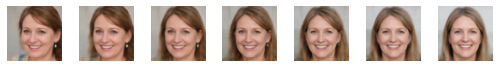

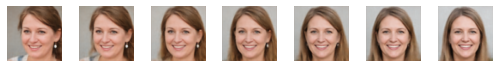

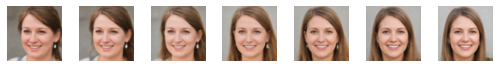

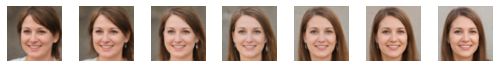

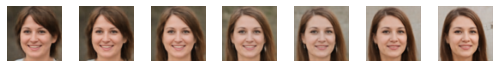

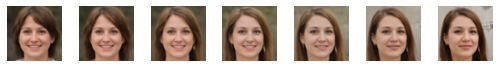

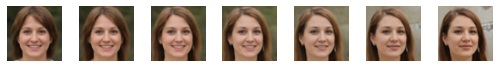

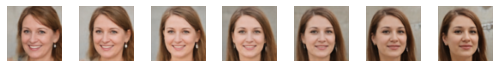

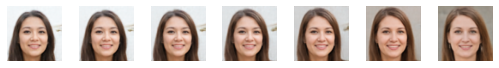

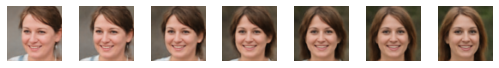

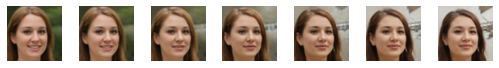

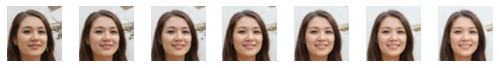

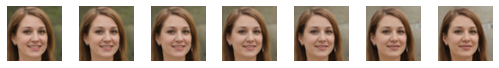

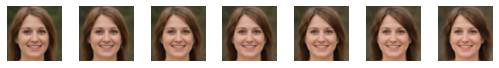

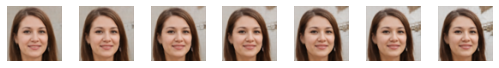

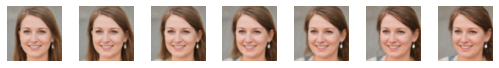

In [60]:
decoded_interp=[]
grid = []
for jj in range(min(params['batch_size'],16)):
    fig, ax = plt.subplots(1,7,figsize=(9,1))
    for ii in range(7):
        decoded_interp=sess.run(decoded_latent, feed_dict={latent_point:interp[ii]})[jj]
        ax[ii].imshow(np.squeeze(decoded_interp.reshape(shape))+0.5, vmin=0,vmax=1, cmap='gray')
        ax[ii].axis('off')
        if jj<=7:
            grid += [np.clip(np.squeeze(decoded_interp.reshape(shape))+0.5,0,1)]
        #print(decoded_interp.shape)
        #ax[ii].set_title(str(interp[ii]))
    #plt.tight_layout()
    np.save(os.path.join(params['plot_dir'],'grid_samples_gan2.npy'),grid)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(os.path.join(params['plot_dir'],'interp%d.pdf'%jj),bbox_inches='tight')
    plt.show()

In [1]:
full_sigma = np.sqrt(np.mean(np.square(x_valid-recs),axis=0))
mean_sigma = np.mean(full_sigma)
mean_var   = np.mean(full_sigma**2)
plt.figure()
plt.title('pixel-wise sigma')
plt.imshow(np.squeeze((full_sigma).reshape(shape)), cmap='gray')
plt.colorbar()
plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'measured_sigma.pdf'),bbox_inches='tight')
plt.show()
params['full_sigma']=full_sigma
pickle.dump(params,open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'wb'))
print('mean variance', mean_var)
print('minimum variance', np.min(full_sigma**2))
print('maximal variance', np.max(full_sigma**2))

NameError: name 'np' is not defined

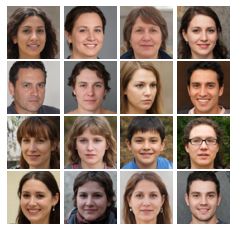

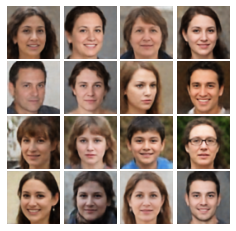

In [43]:

jj=1
plt.figure(figsize=(4,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((d[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'orig_valid_set.pdf'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((rec[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')

plt.savefig(os.path.join(params['plot_dir'],'rec_valid_set.pdf'),bbox_inches='tight')
plt.show()

In [24]:
def evaluate_fid_score(fake_images, real_images,norm=True):
    np.random.shuffle(real_images)
    assert(len(real_images)>=10000)
    assert(len(real_images)>=10000)
    real_images = real_images[0:10000]
    fake_images = fake_images[0:10000]
    real_images = preprocess_fake_images(real_images, norm)
    fake_images = preprocess_fake_images(fake_images, norm)
    print(real_images.shape)
    inception_path = check_or_download_inception()

    create_inception_graph(inception_path)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    print('calculating tf features...')
    real_out = get_activations_tf(real_images, sess)
    fake_out = get_activations_tf(fake_images, sess)
    fid_result = fid_score(real_out, fake_out)

    return fid_result

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
evaluate_fid_score(x_valid.reshape([-1]+shape), random_samples.reshape([-1]+shape))

In [ ]:
evaluate_fid_score(x_valid.reshape([-1]+shape), random_nvp_samples.reshape([-1]+shape))

In [ ]:
evaluate_fid_score(x_valid.reshape([-1]+shape), recs.reshape([-1]+shape))

In [63]:
print(d)

[[-0.24465519 -0.28810513 -0.33652747 ...  0.27215713  0.29806262
   0.31738287]
 [ 0.18449455  0.16048855  0.12376744 ...  0.08460575 -0.11710981
  -0.28709978]
 [-0.23645619 -0.27198136 -0.32171088 ... -0.08109733 -0.12722999
  -0.15388215]
 ...
 [-0.0680446  -0.06897244 -0.1472323  ... -0.15587097 -0.1614913
  -0.22987267]
 [ 0.04784912  0.03457737 -0.02136213 ...  0.06940573 -0.0876784
  -0.21910211]
 [-0.08143732 -0.08705798 -0.16191062 ... -0.1380187  -0.150208
  -0.21156612]]


In [64]:
print(recs)

[[-0.20538148 -0.24376872 -0.3000579  ... -0.02681011 -0.08665314
  -0.15272611]
 [ 0.28899652  0.28507274  0.28217834 ...  0.01589113 -0.01035133
  -0.11977649]
 [ 0.23318791  0.19742578  0.16011238 ...  0.18585092  0.15058976
   0.11506099]
 ...
 [ 0.15110373  0.12067711  0.07778257 ...  0.02146286 -0.14887512
  -0.27462542]
 [ 0.28510314  0.26886636  0.24658418 ...  0.24703938  0.20537835
   0.17685074]
 [-0.34172374 -0.3450213  -0.39697587 ... -0.27159214 -0.2956406
  -0.3587564 ]]


In [32]:
print(decoded_grid.shape)

AttributeError: 'list' object has no attribute 'shape'

In [33]:
decoded_grid

[<tf.Tensor 'module_1_apply_default_56/model/decoder/sub:0' shape=(16, 64, 64, 3) dtype=float32>,
 <tf.Tensor 'module_1_apply_default_57/model/decoder/sub:0' shape=(16, 64, 64, 3) dtype=float32>,
 <tf.Tensor 'module_1_apply_default_58/model/decoder/sub:0' shape=(16, 64, 64, 3) dtype=float32>,
 <tf.Tensor 'module_1_apply_default_59/model/decoder/sub:0' shape=(16, 64, 64, 3) dtype=float32>]

In [ ]:
dd = sess.run(decoded_grid)

In [35]:
dd


NameError: name 'dd' is not defined